# Aphrodisias analysis notebook


In [2]:
from pathlib import Path
import itertools

import pygeoprocessing
from osgeo import gdal
import statistics
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import os
from shapely.geometry import Polygon
from matplotlib import pyplot as plt
import scipy
from scipy.stats import wilcoxon, pointbiserialr
import seaborn


gdal.UseExceptions()


### Defining input datasets

In [ ]:
gis_folder = Path(r"C:\Users\lizad\OneDrive\Desktop\Brown\Dissertation\GIS\Aphrodisias")

target_nodata = -9999.0

dem_raster_path = gis_folder / "processed_data/DEM_clip.tif"
dem_raster_info = pygeoprocessing.get_raster_info(str(dem_raster_path))

slope_raster_path = gis_folder / "slope_35N.tif"
tri_raster_path = gis_folder / "tri_35N.tif"
landcover_raster_path = gis_folder / "landcover_35N.tif"

church_vector_path = gis_folder / "aphrodisias_churches.gpkg"
city_center_vector_path = gis_folder / "center_35N.gpkg"
city_outline_vector_path = 

church_raster_path = gis_folder / "churches_35N.tif"
city_center_raster_path = gis_folder / "center_35N.tif"

# Intermediate files created within the script
## Aligned and clipped rasters
dem_raster_clip = gis_folder / "DEM_UTM_35N_clip.tif"
landcover_raster_clip = gis_folder / "landcover_35N_clip.tif"
slope_raster_clip = gis_folder / "slope_35N_clip.tif"
tri_raster_clip = gis_folder / "tri_35N_clip.tif"

## Landcover reclassified into resistence
landcover_reclass = gis_folder / "landcover_reclass.tif"

## Tobler Hiking rasters
tobler_surface_raster_white = gis_folder / "tobler_surface_white.tif"
tobler_rescale_raster_white = gis_folder / "tobler_rescale_white.tif"

tobler_surface_raster_mp = gis_folder / "tobler_surface_mp.tif"
tobler_rescale_raster_mp = gis_folder / "tobler_rescale_mp.tif"

## Combined cost surface rasters
cost_surface_white = gis_folder / "cost_surface_white.tif"
cost_surface_mp = gis_folder / "cost_surface_mp.tif"


# Parameters for circuitscape church analysis
connectivity_buffer_dist_m = 100
buffered_church_vector = gis_folder / f"churches_buffer_{connectivity_buffer_dist_m}m.gpkg"

circuitscape_church_raster = gis_folder / "circuitscape_church_source.tif"
circuitscape_city_raster = gis_folder / "circuitscape_city_ground.tif"

# Parameters for connectivity analysis and statistics
sample_area_buffer_m = 500
sample_point_iterations = 100

connectivity_raster = gis_folder / "circuitscape/omnidirectional_curmap_250516.tif"

buffered_church_zonal_stats_vector = gis_folder / f"churches_buffer_{connectivity_buffer_dist_m}m_zonal_stats.gpkg"

sample_points_folder = gis_folder / "sample_points_analysis"
sample_points_folder.mkdir(exist_ok=True)
sample_area_vector = sample_points_folder / "sample_area.gpkg"

## Pathnames for saving iteration outputs
sample_points_vector_name = "sample_points_{}.gpkg"
buffered_sample_points_vector_name = "buffered_sample_points_{}" + f"_{connectivity_buffer_dist_m}m.gpkg"
buffered_sample_points_zonal_stats_vector_name = "zonal_stats_sample_points_{}" + f"_{connectivity_buffer_dist_m}m_zonal_stats.gpkg"

combined_stats_vector_pathname =  "connectivity_statistics_sample_points_{}.gpkg"  # replace with sample number
histogram_name = "histogram_sample_{}_{}.png"  # replace with sample number, zonal_stat

combined_statistics_csv = sample_points_folder / "combined_statistical_results.csv"



### Rasterizing Churches and city center to match the DEM

In [ ]:
# Create and burn church locations
if not church_raster_path.exists:
    pygeoprocessing.new_raster_from_base(
        str(dem_raster_path),
        str(church_raster_path),
        gdal.GDT_Byte,
        [0],
    )
    pygeoprocessing.rasterize(
    str(church_vector_path),
    str(church_raster_path),
    [1],
    )

# Create and burn city center
if not city_center_raster_path.exists:
    pygeoprocessing.new_raster_from_base(
        str(dem_raster_path),
        str(city_center_raster_path),
        gdal.GDT_Int16,
        [0],
    )
    pygeoprocessing.rasterize(
    str(city_center_vector_path),
    str(city_center_raster_path),
        [1],
    )

### Calculate slope and Terrain Ruggedness Index from DEM

In [ ]:
slope_gdal_ds = gdal.DEMProcessing(str(slope_raster_path), str(dem_raster_path), "slope")
del slope_gdal_ds

# pygeoprocessing.calculate_slope((str(dem_raster_path), 1), str(slope_raster_path))

tri_gdal_ds = gdal.DEMProcessing(str(tri_raster_path), str(dem_raster_path), "tri")
del tri_gdal_ds

### Normalize input datasets

In [ ]:
#Align and clip landscape data to DEM extent
dem_raster_info = pygeoprocessing.get_raster_info(str(dem_raster_path))

pygeoprocessing.align_and_resize_raster_stack(
    [str(dem_raster_path), str(landcover_raster_path), str(slope_raster_path), str(tri_raster_path)],
    [str(dem_raster_clip), str(landcover_raster_clip), str(slope_raster_clip), str(tri_raster_clip)],
    ["near", "near", "near", "near"],
    dem_raster_info["pixel_size"],
    dem_raster_info["bounding_box"],
    raster_align_index=0,
)

### Reclassify landcover into cost surface

In [ ]:
reclass_df = pd.read_csv("./data/esa_worldcover_classification.csv")
cost_value = "cost_value"

reclass_dict = reclass_df.set_index("lucode").to_dict()[cost_value]

pygeoprocessing.reclassify_raster(
    (str(landcover_raster_clip),1),
    reclass_dict,
    str(landcover_reclass),
    gdal.GDT_Float32,
    target_nodata,
)

### Calculate Tobler's hiking function (Tobler 1993)

In [ ]:
# tobler_surface_raster = gis_folder / "tobler_surface.tif"

# slope_raster_info = pygeoprocessing.get_raster_info(str(slope_raster_clip))
# slope_cell_resolution = statistics.mean([abs(x) for x in slope_raster_info["pixel_size"]])
# slope_nodata = slope_raster_info["nodata"][0]

# # def tobler_op(slope_array):
# #     result = (slope_cell_resolution/1000)/(6*np.exp(-3.5*np.abs(np.tan(slope_array*math.pi/180)+0.05)))
# #     return result
# # def tobler_op(slope):
# #     result = (slope_cell_resolution/1000)/(6*np.exp(-3.5*np.abs(slope+0.05)))
# #     return result

# def tobler_op(slope_array):
#     # Make an array of the same shape full of nodata
#     output = np.full(slope_array.shape, slope_nodata)

#     # Make a masking array to ignore all nodata areas in the original data
#     valid_mask = np.full(slope_array.shape, True)
#     valid_mask &= ~pygeoprocessing.array_equals_nodata(slope_array, slope_nodata)

#     output[valid_mask] = (slope_cell_resolution/1000)/(6*np.exp(-3.5*np.abs(np.tan(slope_array[valid_mask])+0.05)))
#     output[valid_mask] = (slope_cell_resolution/1000)/(6*np.exp(-3.5*np.abs(np.tan(slope_array[valid_mask]*math.pi/180)+0.05)))

#     return output

# pygeoprocessing.raster_calculator(
#     [(str(slope_raster_clip),1)], 
#     tobler_op,
#     str(tobler_surface_raster),
#     gdal.GDT_Float32,
#     target_nodata,
#     calc_raster_stats=True
# )


# # Define Tobler rescaling function
# def tobler_rescale_op(tobler_surface_array, upper_limit=0.1666667, lower_limit=0.0):
#     # Make an array of the same shape full of nodata
#     output = np.full(tobler_surface_array.shape, target_nodata)

#     # Make a masking array to ignore all nodata areas in the original data
#     valid_mask = np.full(tobler_surface_array.shape, True)
#     valid_mask &= ~pygeoprocessing.array_equals_nodata(tobler_surface_array, target_nodata)

#     # Calculate initial rescaling
#     output[valid_mask] = (tobler_surface_array[valid_mask] - lower_limit)/(upper_limit - lower_limit)

#     # Force values larger than the upper_limit to equal one
#     upper_limit_mask = (tobler_surface_array >= upper_limit) & valid_mask
#     output[upper_limit_mask] = 1

#     # Force values smaller than the lower_limit to equal zero
#     lower_limit_mask = (tobler_surface_array <= lower_limit) & valid_mask
#     output[lower_limit_mask] = 0

#     return output

# tobler_rescale_raster = gis_folder / "tobler_rescale.tif"

# # Rescaling Tobler's original function
# if tobler_rescale_raster.exists():
#     tobler_rescale_raster.unlink()
# pygeoprocessing.raster_calculator(
#     [(str(tobler_surface_raster),1)], 
#     tobler_rescale_op,
#     str(tobler_rescale_raster),
#     gdal.GDT_Float32,
#     target_nodata,
# )

C:\Users\lizad\AppData\Local\Temp\ipykernel_230392\1432203259.py:22: RuntimeWarning: divide by zero encountered in divide
  output[valid_mask] = (slope_cell_resolution/1000)/(6*np.exp(-3.5*np.abs(np.tan(slope_array[valid_mask])+0.05)))
C:\Users\lizad\AppData\Local\Temp\ipykernel_230392\1432203259.py:22: RuntimeWarning: overflow encountered in divide
  output[valid_mask] = (slope_cell_resolution/1000)/(6*np.exp(-3.5*np.abs(np.tan(slope_array[valid_mask])+0.05)))
C:\Users\lizad\AppData\Local\Temp\ipykernel_230392\1432203259.py:46: RuntimeWarning: overflow encountered in divide
  output[valid_mask] = (tobler_surface_array[valid_mask] - lower_limit)/(upper_limit - lower_limit)


### Calculate modified Tobler's hiking function (White 2015)

In [ ]:
slope_raster_info = pygeoprocessing.get_raster_info(str(slope_raster_clip))
slope_cell_resolution = statistics.mean([abs(x) for x in slope_raster_info["pixel_size"]])
slope_nodata = slope_raster_info["nodata"][0]

# def tobler_op(slope_array):
#     result = (slope_cell_resolution/1000)/(6*np.exp(-3.5*np.abs(np.tan(slope_array*math.pi/180)+0.05)))
#     return result
# def tobler_op(slope):
#     result = (slope_cell_resolution/1000)/(6*np.exp(-3.5*np.abs(slope+0.05)))
#     return result

def tobler_op_white(slope_array):
    # Make an array of the same shape full of nodata
    output = np.full(slope_array.shape, slope_nodata)

    # Make a masking array to ignore all nodata areas in the original data
    valid_mask = np.full(slope_array.shape, True)
    valid_mask &= ~pygeoprocessing.array_equals_nodata(slope_array, slope_nodata)

    output[valid_mask] = (slope_cell_resolution/1000)/(6*np.exp(-3.5*np.abs(np.tan(slope_array[valid_mask]*math.pi/180)+0.05)))

    return output

pygeoprocessing.raster_calculator(
    [(str(slope_raster_clip),1)], 
    tobler_op_white,
    str(tobler_surface_raster_white),
    gdal.GDT_Float32,
    target_nodata,
    calc_raster_stats=True
)

# Define Tobler rescaling function to convert to 0-1 index
def tobler_rescale_op(tobler_surface_array, upper_limit=0.1666667, lower_limit=0.0):
    # Make an array of the same shape full of nodata
    output = np.full(tobler_surface_array.shape, target_nodata)

    # Make a masking array to ignore all nodata areas in the original data
    valid_mask = np.full(tobler_surface_array.shape, True)
    valid_mask &= ~pygeoprocessing.array_equals_nodata(tobler_surface_array, target_nodata)

    # Calculate initial rescaling
    output[valid_mask] = (tobler_surface_array[valid_mask] - lower_limit)/(upper_limit - lower_limit)

    # Force values larger than the upper_limit to equal one
    upper_limit_mask = (tobler_surface_array >= upper_limit) & valid_mask
    output[upper_limit_mask] = 1

    # Force values smaller than the lower_limit to equal zero
    lower_limit_mask = (tobler_surface_array <= lower_limit) & valid_mask
    output[lower_limit_mask] = 0

    return output


# Rescaling Tobler's original function
if tobler_rescale_raster_white.exists():
    tobler_rescale_raster_white.unlink()
pygeoprocessing.raster_calculator(
    [(str(tobler_surface_raster_white),1)], 
    tobler_rescale_op,
    str(tobler_rescale_raster_white),
    gdal.GDT_Float32,
    target_nodata,
)

### Calculate modified Tobler's hiking function (Marquez-Perez 2017)

In [ ]:
slope_raster_info = pygeoprocessing.get_raster_info(str(slope_raster_clip))
slope_cell_resolution = statistics.mean([abs(x) for x in slope_raster_info["pixel_size"]])
slope_nodata = slope_raster_info["nodata"][0]

# def tobler_op(slope_array):
#     result = (slope_cell_resolution/1000)/(6*np.exp(-3.5*np.abs(np.tan(slope_array*math.pi/180)+0.05)))
#     return result
# def tobler_op(slope):
#     result = (slope_cell_resolution/1000)/(6*np.exp(-3.5*np.abs(slope+0.05)))
#     return result

def tobler_op_mp(slope_array):
    # Make an array of the same shape full of nodata
    output = np.full(slope_array.shape, slope_nodata)

    # Make a masking array to ignore all nodata areas in the original data
    valid_mask = np.full(slope_array.shape, True)
    valid_mask &= ~pygeoprocessing.array_equals_nodata(slope_array, slope_nodata)

    output[valid_mask] = (slope_cell_resolution/1000)/(4.8*np.exp(-5.3*np.abs((np.tan(slope_array[valid_mask]*math.pi/180)*0.7)+0.03)))

    return output

pygeoprocessing.raster_calculator(
    [(str(slope_raster_clip),1)], 
    tobler_op_mp,
    str(tobler_surface_raster_mp),
    gdal.GDT_Float32,
    target_nodata,
    calc_raster_stats=True
)


# Rescaling Tobler's original function
if tobler_rescale_raster_mp.exists():
    tobler_rescale_raster_mp.unlink()
pygeoprocessing.raster_calculator(
    [(str(tobler_surface_raster_mp),1)], 
    tobler_rescale_op,
    str(tobler_rescale_raster_mp),
    gdal.GDT_Float32,
    target_nodata,
)

### Create multicriteria cost surface (White 2015)

In [ ]:
# Get nodata values for toblers and lulc
landcover_raster_nodata = pygeoprocessing.get_raster_info(str(landcover_reclass))["nodata"][0]
tobler_raster_nodata = pygeoprocessing.get_raster_info(str(tobler_rescale_raster_white))["nodata"][0]


def weighted_average_op(tobler_array, lulc_cost_array, tobler_weight=0.8, lulc_cost_weight=0.2):
    # Make an array of the same shape full of nodata
    output = np.full(tobler_array.shape, target_nodata)

    # Make a masking array to ignore all nodata areas in the original data
    valid_mask = np.full(tobler_array.shape, True)
    valid_mask &= ~pygeoprocessing.array_equals_nodata(tobler_array, target_nodata)
    valid_mask &= ~pygeoprocessing.array_equals_nodata(lulc_cost_array, target_nodata)

    # Calculate weighted average
    output[valid_mask] = ((tobler_array[valid_mask]*tobler_weight) + (lulc_cost_array[valid_mask]*lulc_cost_weight)) / (tobler_weight+lulc_cost_weight)

    return output 

if cost_surface_white.exists():
    cost_surface_white.unlink()
pygeoprocessing.raster_calculator(
    [(str(tobler_rescale_raster_white),1),(str(landcover_reclass),1)],
    weighted_average_op,
    str(cost_surface_white),
    gdal.GDT_Float32,
    target_nodata,
)

### Create multicritera cost surface (Marquez-Perez 2017)

In [ ]:
# Get nodata values for toblers and lulc
landcover_raster_nodata = pygeoprocessing.get_raster_info(str(landcover_reclass))["nodata"][0]
tobler_raster_nodata = pygeoprocessing.get_raster_info(str(tobler_rescale_raster_mp))["nodata"][0]

if cost_surface_mp.exists():
    cost_surface_mp.unlink()
pygeoprocessing.raster_calculator(
    [(str(tobler_rescale_raster_mp),1),(str(landcover_reclass),1)],
    weighted_average_op,
    str(cost_surface_mp),
    gdal.GDT_Float32,
    target_nodata,
)

### Create 'Advanced' Circuitscape input files

In [ ]:

# Buffer church locations
church_location_gdf = gpd.read_file(church_vector_path)
church_location_gdf.geometry = church_location_gdf.buffer(connectivity_buffer_dist_m)
church_location_gdf.to_file(buffered_church_vector)

# Rasterize buffered church locations
pygeoprocessing.new_raster_from_base(
    str(dem_raster_path),
    str(circuitscape_church_raster),
    gdal.GDT_Int16,
    [int(target_nodata)],
)

pygeoprocessing.rasterize(
    str(buffered_church_vector),
    str(circuitscape_church_raster),
    [1],
)

# Rasterize city
pygeoprocessing.new_raster_from_base(
    str(dem_raster_path),
    str(circuitscape_city_raster),
    gdal.GDT_Int16,
    [int(target_nodata)],
)

pygeoprocessing.rasterize(
    str(city_outline_vector_path),
    str(circuitscape_city_raster),
    [0],
)

### Run tiled Circuitscape method

In [ ]:
# from pathlib import Path
# import circuitscape

# gis_folder = Path(r"C:\Users\lizad\OneDrive\Desktop\Brown\Dissertation\GIS")


# cost_surface_raster = gis_folder / "cost_surface.tif"
# workspace_path = gis_folder/ "circuitscape"
# seed_ini = gis_folder / "circuitscape/blank_circuitscape_ini.ini"
# # seed_ini = gis_folder / "circuitscape/blank_circuitscape_manual.ini"

# circuitscape.execute(cost_surface_raster, seed_ini, workspace_path, keep_intermediates=True)

### Analyzing connectivity by church

In [ ]:

current_var_structure = "omnidirectional_curmap_{}"
church_var = "church"

# Read in church locations
church_location_gdf = gpd.read_file(church_vector_path)

# Get connectivity raster info
connectivity_raster_info = pygeoprocessing.get_raster_info(str(connectivity_raster))

# Get study area boundary for sample points analysis
sample_area_gdf = church_location_gdf.dissolve().envelope.buffer(sample_area_buffer_m)
sample_area_gdf.to_file(sample_area_vector)
                 
# bbox = connectivity_raster_info["bounding_box"]
# sample_area_gdf = gpd.GeoDataFrame(pd.DataFrame(['bbox'], columns = ['geom']),
#          crs = connectivity_raster_info["projection_wkt"],
#          geometry = [Polygon([[bbox[0], bbox[1]],
#         [bbox[2],bbox[1]],
#         [bbox[2],bbox[3]],
#         [bbox[0], bbox[3]]])
# ])


# Select number of sample points equal to the number of churches
n_sample_points = len(church_location_gdf)


# Define zonal statistics function
def connectivity_zonal_stats(connectivity_raster, vector, output_vector, join_vector=None):
    zonal_stats_dict = pygeoprocessing.zonal_statistics(
        (str(connectivity_raster),1),
        str(vector),
    )
        
    zonal_stats_df = pd.DataFrame(zonal_stats_dict).T
    zonal_stats_df.index = zonal_stats_df.index -1
    zonal_stats_df["mean"] = zonal_stats_df["sum"] / zonal_stats_df["count"]
    zonal_stats_df = zonal_stats_df.rename(columns={c: f"omnidirectional_curmap_{c}" for c in zonal_stats_df.columns})

    vector_gdf = gpd.read_file(join_vector) if join_vector is not None else gpd.read_file(vector)
    zonal_stats_gdf = vector_gdf.join(zonal_stats_df)
    zonal_stats_gdf.to_file(output_vector)

# Run zonal stats on churches
connectivity_zonal_stats(connectivity_raster, buffered_church_vector, buffered_church_zonal_stats_vector, join_vector=church_vector_path)

# Read in church zonal stats data and make "church" boolean column
church_stats_gdf = gpd.read_file(buffered_church_zonal_stats_vector)
church_stats_gdf[church_var] = True

# Extract all raster connectivity values
connectivity_array = pygeoprocessing.raster_to_numpy_array(str(connectivity_raster))
connectivity_array[connectivity_array==connectivity_raster_info["nodata"]] = np.nan
connectivity_array = connectivity_array[~np.isnan(connectivity_array)]

# Iterate through sample point attempts, storing statistical outputs
zonal_outputs = ["min", "max", "mean"]
methods = ["pointbiserial", "wilcoxon"]
values = ["statistic", "p_value"]
data_dict = {"sample_iteration":[]}
data_dict_key_format = "{}_{}_{}"
data_dict.update({data_dict_key_format.format(zonal, method, value): [] for zonal, method, value in itertools.product(zonal_outputs,methods,values)})

for i in range(sample_point_iterations):
    data_dict["sample_iteration"].append(i)

    # Name outputs based on the sample point number
    sample_points_vector = sample_points_folder / sample_points_vector_name.format(i)
    buffered_sample_points_vector = sample_points_folder / buffered_sample_points_vector_name.format(i)
    buffered_sample_points_zonal_stats_vector = sample_points_folder / buffered_sample_points_zonal_stats_vector_name.format(i)
    combined_stats_vector_path = sample_points_folder / combined_stats_vector_pathname.format(i)

    # Create sample points from study area bounds
    sampled_points = sample_area_gdf.sample_points(n_sample_points).explode()
    sampled_points.to_file(sample_points_vector)

    # Buffer sample points for zonal statistics
    sampled_points = sampled_points.buffer(connectivity_buffer_dist_m)
    sampled_points.to_file(buffered_sample_points_vector)

    # Run zonal stats on sample points
    connectivity_zonal_stats(
        connectivity_raster,
        buffered_sample_points_vector,
        buffered_sample_points_zonal_stats_vector,
        join_vector=sample_points_vector)

    # Read in sample zonal stats data and make "church" boolean column
    sample_points_stats_gdf = gpd.read_file(buffered_sample_points_zonal_stats_vector)
    sample_points_stats_gdf[church_var] = False

    # Merge points into single dataset with church boolean field
    combined_stats_gdf = pd.concat([church_stats_gdf, sample_points_stats_gdf])
    combined_stats_gdf.to_file(combined_stats_vector_path)

    # Iterate through zonal stats type (min max mean) and calculate statistics on each
    for zonal in zonal_outputs:
        # stats_gdf = combined_stats_gdf[[current_var,church_var]].dropna()
        current_var = current_var_structure.format(zonal)

        stats_gdf = combined_stats_gdf[[current_var,church_var]]

        current_col = stats_gdf[current_var]
        church_col = stats_gdf[church_var]

        # Run correlation analysis on sample points vs churches
        pointbiserial_statistic, pointbiserial_p_value = pointbiserialr(church_col, current_col, nan_policy="omit")
        data_dict[data_dict_key_format.format(zonal,"pointbiserial","statistic")].append(pointbiserial_statistic)
        data_dict[data_dict_key_format.format(zonal,"pointbiserial","p_value")].append(pointbiserial_p_value)

        # Run wilcoxon thingy
        church_current_values = current_col[church_col]
        sample_current_values = current_col[~church_col]
        wilcoxon_statistic, wilcoxon_p_value = wilcoxon(church_current_values, sample_current_values, nan_policy="omit")
        data_dict[data_dict_key_format.format(zonal,"wilcoxon","statistic")].append(wilcoxon_statistic)
        data_dict[data_dict_key_format.format(zonal,"wilcoxon","p_value")].append(wilcoxon_p_value)

        # Create connectivity histogram
        fig, axs = plt.subplots(1, 1, figsize =(10, 7))

        # Plot raster connectivity histogram
        plt.hist(connectivity_array, color="skyblue", edgecolor="black") 
        plt.xlabel(f'Connectivity ({zonal})')
        plt.ylabel('Frequency')
        plt.title('Shart frequency') 
        axs.yaxis.set_ticks_position('none') 
        axs.axes.yaxis.set_ticklabels([]) 

        # # Plot church/sample locations as vertical lines
        # plt.vlines(x[y],ymin=0, ymax=3500000, colors="red")
        # plt.vlines(x[~y],ymin=0, ymax=3500000, colors="grey")

        # Create random array of values for scatterplot visualization (y axis of churches)
        rng = np.random.default_rng()
        sample_random_y = rng.uniform(100000,150000,len(current_col[~church_col]))
        church_random_y = rng.uniform(250000,350000,len(current_col[church_col]))

        # Plot church/sample locations as scatterplots
        plt.scatter(current_col[church_col],church_random_y, c="red", s=100, marker="o", edgecolors='black')
        plt.scatter(current_col[~church_col],sample_random_y, c="grey",s=100, marker="o", edgecolors='black')

        # Save figure
        histogram_figure = sample_points_folder / histogram_name.format(i,zonal)
        plt.savefig(histogram_figure, dpi=300)
        plt.close()
        # plt.show()

statistics_df = pd.DataFrame(data_dict)
statistics_df.to_csv(combined_statistics_csv)

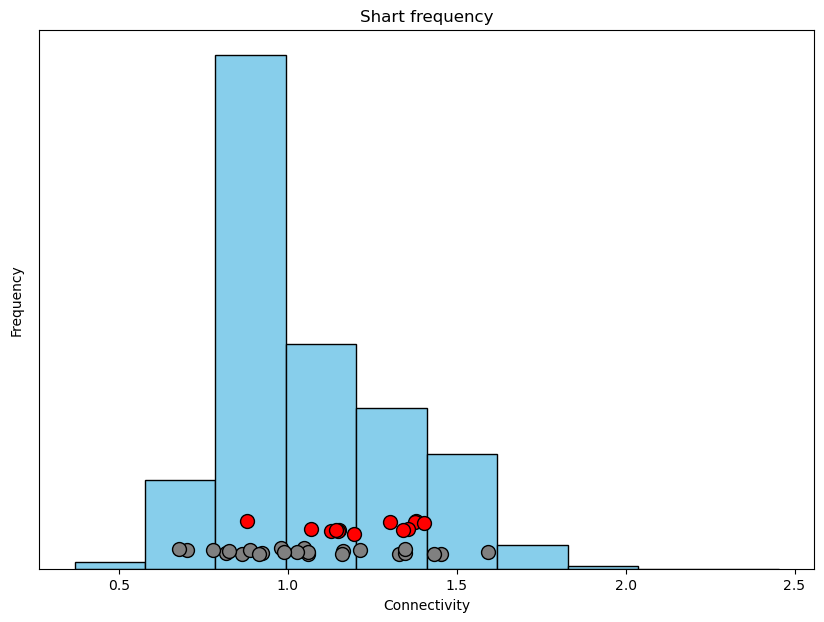

ShapiroResult(statistic=np.float64(0.9734321665836516), pvalue=np.float64(0.5090409998027654))

In [ ]:
# Figure iteration

# Create connectivity histogram
fig, axs = plt.subplots(1, 1, figsize =(10, 7))

# Plot raster connectivity histogram
plt.hist(connectivity_array, color="skyblue", edgecolor="black") 
plt.xlabel('Connectivity')
plt.ylabel('Frequency')
plt.title('Shart frequency') 
axs.yaxis.set_ticks_position('none') 
axs.axes.yaxis.set_ticklabels([]) 

# # Plot church/sample locations as vertical lines
# plt.vlines(x[y],ymin=0, ymax=3500000, colors="red")
# plt.vlines(x[~y],ymin=0, ymax=3500000, colors="grey")

# Create random array of values for scatterplot visualization (y axis of churches)
rng = np.random.default_rng()
sample_random_y = rng.uniform(100000,150000,len(current_col[~church_col]))
church_random_y = rng.uniform(250000,350000,len(current_col[church_col]))

# Plot church/sample locations as scatterplots
plt.scatter(current_col[church_col],church_random_y, c="red", s=100, marker="o", edgecolors='black')
plt.scatter(current_col[~church_col],sample_random_y, c="grey",s=100, marker="o", edgecolors='black')

# Save figure
plt.show()

from scipy.stats import shapiro
from scipy.stats import lognorm

from scipy.stats import wilcoxon

pointbiserialr(church_col, current_col)
wilcoxon()



In [185]:
test = [1,2,3,4]
print(len(test))
test_2 = test[:len(test)]

4
